### Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

In [3]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [4]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

### prepare input 

In [5]:
#files 
#g1,g2=0,0
#g1,g2=.01,.01
#g1,g2=-.01,-.01
#g1,g2=.02,.02
#g1,g2=-.02,-.02
#respectively. 
files = dict(
final_fits1 = 'Users/Ismael/aegis/data/fits_files/final_fits1.fits', 
final_fits2 = 'Users/Ismael/aegis/data/fits_files/final_fits2.fits', 
final_fits3 = 'Users/Ismael/aegis/data/fits_files/final_fits3.fits', 
final_fits4 = 'Users/Ismael/aegis/data/fits_files/final_fits4.fits', 
final_fits5 = 'Users/Ismael/aegis/data/fits_files/final_fits5.fits', 
)

files_temps = dict() 
for f in files: 
    l = files[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    files_temps[f] = temp_file

    
files_slac = dict()
for f in files: 
    l = files[f].split("/")
    index_data = l.index("aegis")
    str_slac = "/".join(l[index_data:])
    slac_file = '{0}{1}'.format('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/',str_slac)
    files_slac[f] = slac_file

### Samples 

In [6]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter duplicates and rare(bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [7]:
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(cat['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated objects
    duplic_bool = []
    non_duplic_bool = []
    for x in list(cat['db_id']):
        if x in duplic:
            duplic_bool.append(True)
            non_duplic_bool.append(False)
        else:
            duplic_bool.append(False)
            non_duplic_bool.append(True)
            
    duplic_cat = cat[np.array(duplic_bool)]
    non_duplic_cat = cat[np.array(non_duplic_bool)]  #decided to just remove duplicated 
    
    return non_duplic_cat

### Read and filter out duplicated and bad objects.

In [8]:
g1s = [0.,.01,-.01,.02,-.02]
cats = []
for key in ['final_fits1','final_fits2','final_fits3','final_fits4','final_fits5']:
    results = fits.open(files_temps[key])
    cats.append(get_non_duplicated_cat(not_bad(Table.read(results,hdu=1))))


In [9]:
names = ['One square degree galaxies with g1 = 0','One square degree galaxies with g1 = 0.1','One square degree galaxies with g1 = -0.1','One square degree galaxies with g1 = 0.2','One square degree galaxies with g1 = -0.2']

### Interesting plots comparing catalogs 

In [11]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_hists(name,cat,colors,g_min,g_max,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    
    #annotate 
    mean_cut_iso = np.mean(cut_biasiso(cat,10.)['bias_g1'])
    std_cut_iso = np.std(cut_biasiso(cat,10.)['bias_g1'])
    median_iso = np.median(cat['bias_g1'])
    mad_iso = mad(cut_biasiso(cat,10.)['bias_g1'])
    error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat,10)))
    error_mad_iso = mad_iso/np.sqrt(len(cut_biasiso(cat,10.)['bias_g1']))
    
    mean_cut_grp = np.mean(cut_biasgrp(cat,10)['bias_g1_grp'])
    std_cut_grp = np.std(cut_biasgrp(cat,10)['bias_g1_grp'])
    median_grp = np.median(cat['bias_g1_grp'])
    mad_grp = mad(cut_biasgrp(cat,10)['bias_g1_grp'])
    error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat,10)))
    error_mad_grp = mad_grp/np.sqrt(len(cut_biasgrp(cat,10)['bias_g1_grp']))
    
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('MAD (using cut): {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('MAD (using cut): {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=12)

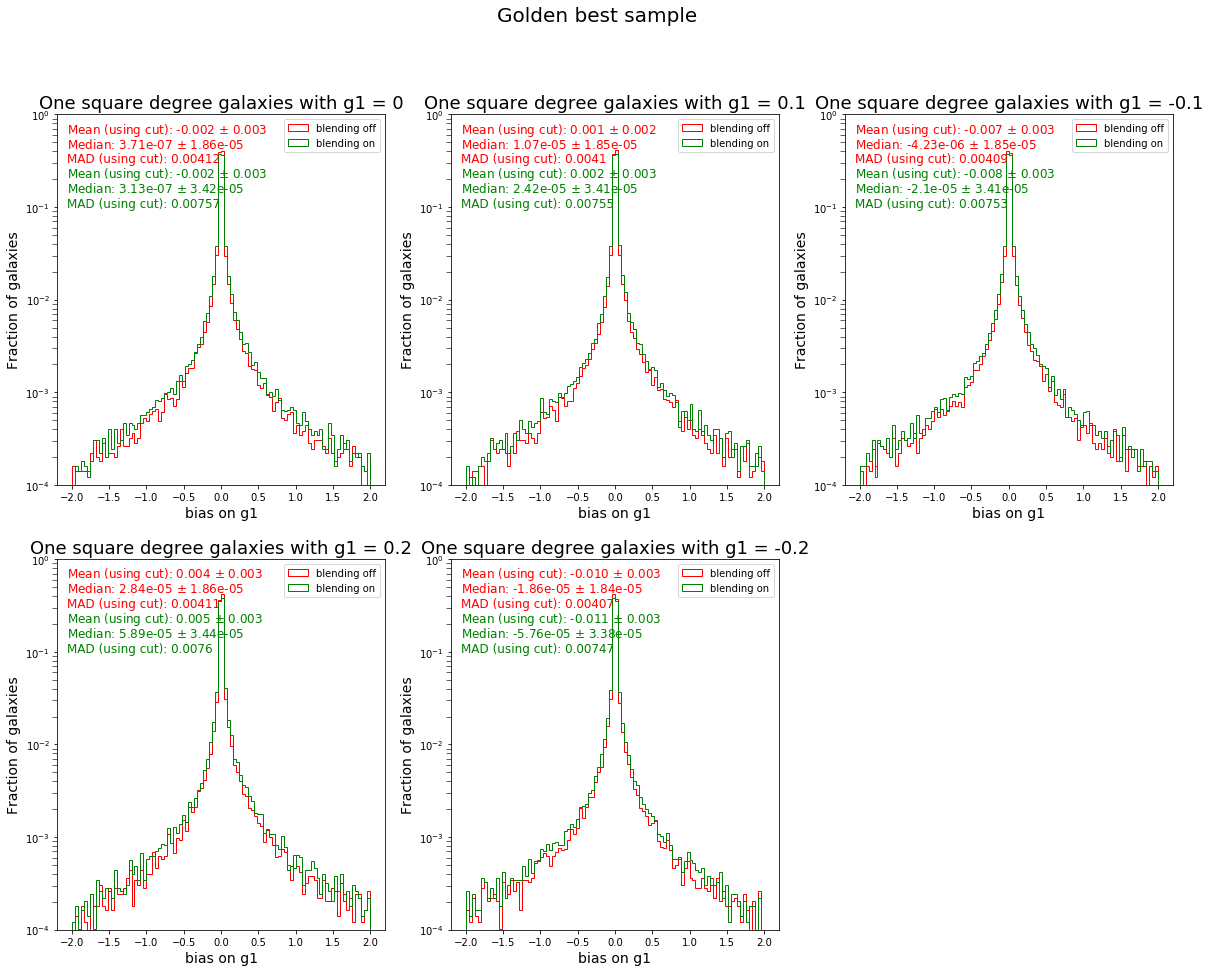

In [12]:
#compare all of them 
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,3
colors = ['red','green']
g_min,g_max = -2.,2.
plt.suptitle('Golden best sample', fontsize=20)
for i,(name,cat) in enumerate(zip(names,cats)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,gold(best(cat)),colors,g_min,g_max)
    plt.legend(prop={'size':10},loc=1)


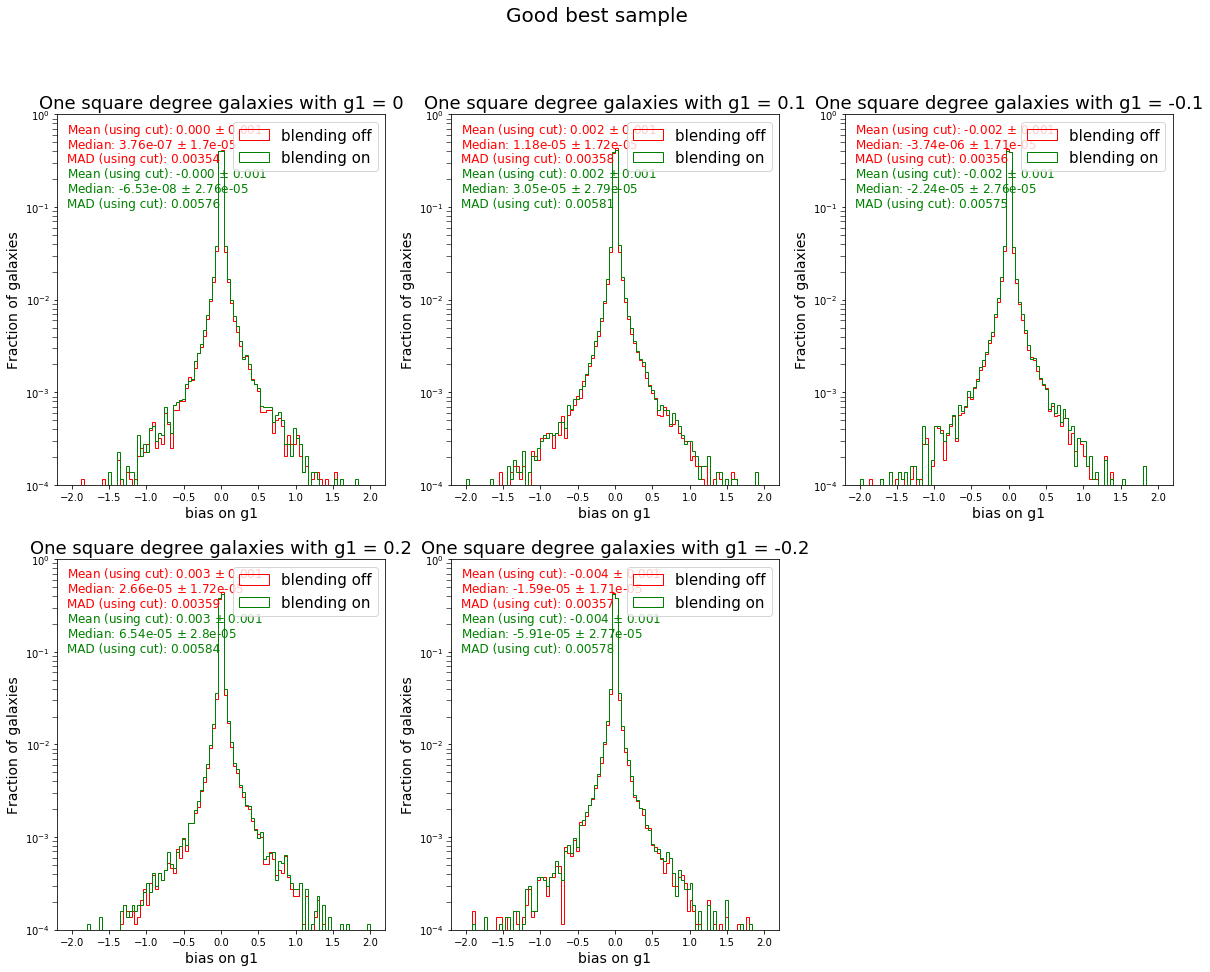

In [13]:
#compare all of them 
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,3
colors = ['red','green']
g_min,g_max = -2.,2.
plt.suptitle('Good best sample', fontsize=20)
for i,(name,cat) in enumerate(zip(names,cats)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,good(best(cat)),colors,g_min,g_max)
    plt.legend(prop={'size':15},loc=1)



In [16]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_cumhists(name,cat,colors,g_min,g_max,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel('absolute bias on g1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(np.absolute(cat['bias_g1']),range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1']))/len(cat['bias_g1']))
    plt.hist(np.absolute(cat['bias_g1_grp']),range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1_grp']))/len(cat['bias_g1_grp']))
    #plt.yscale('log')
#     plt.ylim(0,1.)

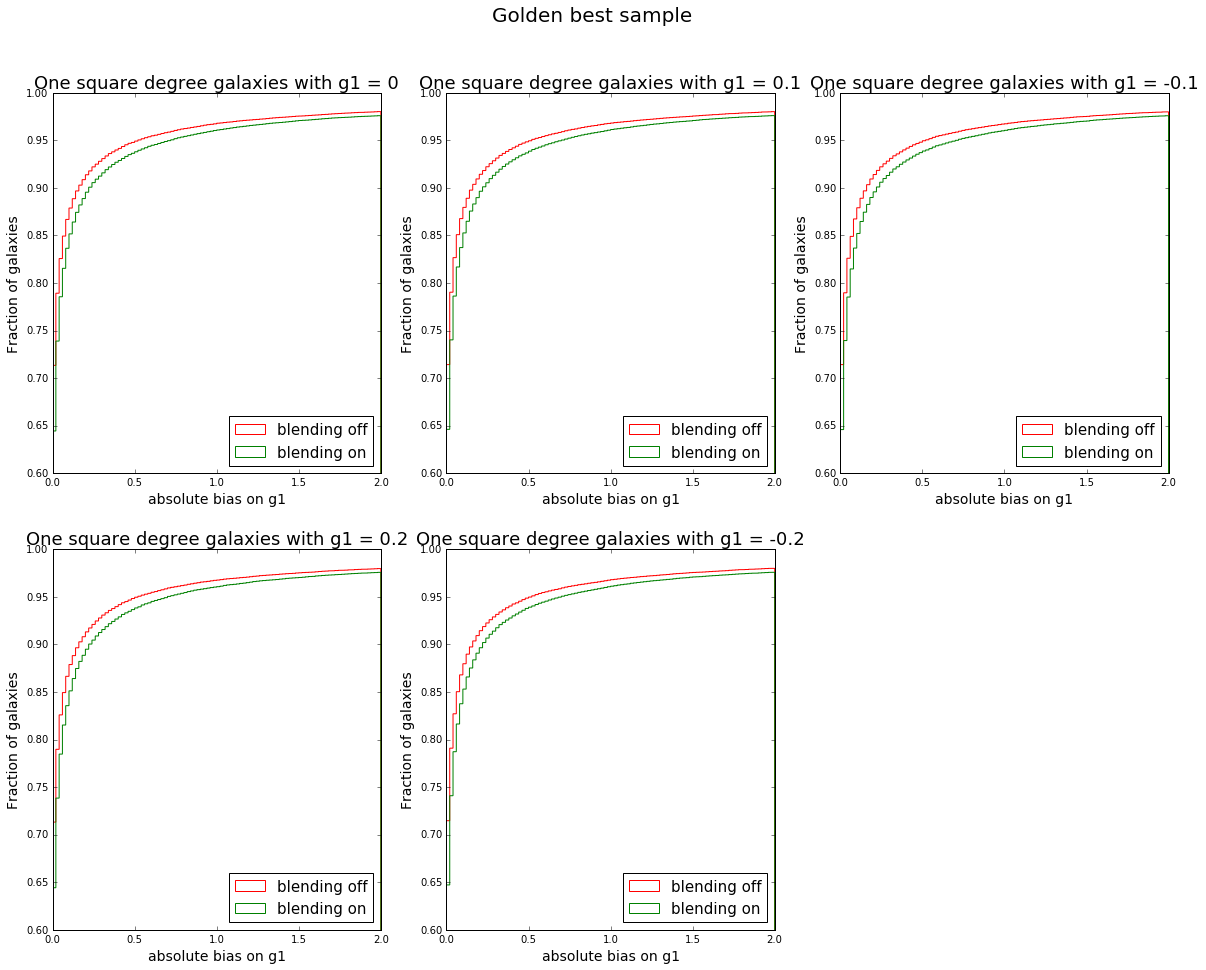

In [17]:
#compare all of them cumulative
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,3
colors = ['red','green']
g_min,g_max = 0.,2.
plt.suptitle('Golden best sample', fontsize=20)
for i,(name,cat) in enumerate(zip(names,cats)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhists(name,gold(best(cat)),colors,g_min,g_max)
    plt.legend(prop={'size':15},loc=4)
    plt.ylim(.6,1.0)

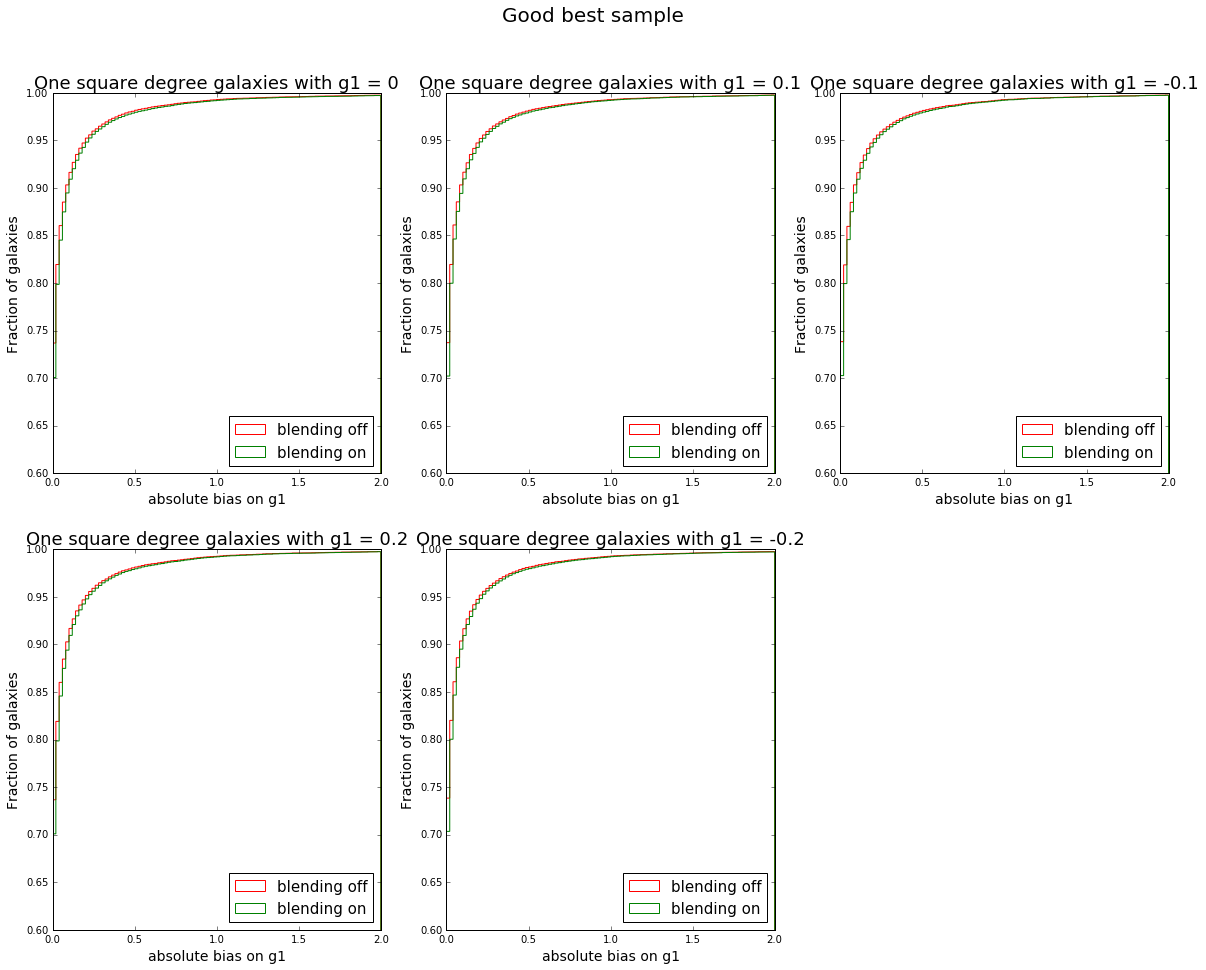

In [18]:
#compare all of them cumulative
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,3
colors = ['red','green']
g_min,g_max = 0.,2.
plt.suptitle('Good best sample', fontsize=20)
for i,(name,cat) in enumerate(zip(names,cats)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhists(name,good(best(cat)),colors,g_min,g_max)
    plt.legend(prop={'size':15},loc=4)
    plt.ylim(.6,1.0)

## money plot with MAD/sqrt(N) as error bars 

medians grp: [3.1285799e-07, 2.4183353e-05, -2.1035577e-05, 5.8874371e-05, -5.7576479e-05]
sigmas grp: [0.0078027435, 0.0077649918, 0.0077586989, 0.0078593884, 0.0076910732]
errs grp: [3.5091998131324439e-05, 3.4957231453331596e-05, 3.4936690820762552e-05, 3.5363207632837823e-05, 3.4622702924392929e-05]
Beta: [  2.78396148e-03   9.35196163e-07]
Beta Std Error: [  1.51919330e-04   2.14913176e-06]
Beta Covariance: [[  6.81650678e-02   1.07068014e-05]
 [  1.07068014e-05   1.36414922e-05]]
Residual Variance: 3.38582264087e-07
Inverse Condition #: 0.0143406072199
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [3.7085169e-07, 1.0713732e-05, -4.2288848e-06, 2.8359331e-05, -1.8604682e-05]
sigmas iso: [0.0042288471, 0.0042014988, 0.0042084823, 0.0042245211, 0.0041913195]
errs iso: [1.9018784258224097e-05, 1.8914735461976502e-05, 1.8950399835826401e-05, 1.900817342610184e-05, 1.8867953027620007e-05]
Beta: [  1.09060841e-03   3.32043505e-06]
Beta Std Error: [  1.19170009e-04   1

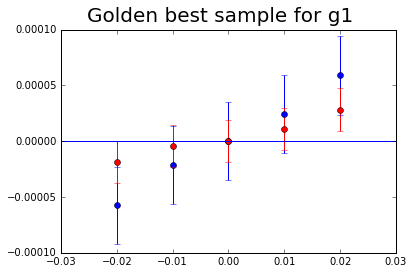

In [12]:
import scipy.odr

plt.suptitle('Golden best sample for g1 ', fontsize=20)
#
medians = [np.median(gold(best(cat))['bias_g1_grp']) for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g1_grp']) for cat in cats]
errs = [mad(gold(best(cat))['bias_g1_grp'])/np.sqrt(len(gold(best(cat)))) for cat in cats]


print 'medians grp:',medians
print 'sigmas grp:',sigmas 
print 'errs grp:',errs

plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',)
plt.ylim(-1e-4,1e-4)


def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#unblended
medians = [np.median(gold(best(cat))['bias_g1']) for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g1']) for cat in cats]
errs = [mad(gold(best(cat))['bias_g1'])/np.sqrt(len(gold(best(cat)))) for cat in cats]
print 'medians iso:',medians
print 'sigmas iso:',sigmas 
print 'errs iso:',errs
plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red')
plt.ylim(-1e-4,1e-4)
plt.axhline(0)

plt.xlim(-.03,.03)

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()




medians grp: [1.5166898e-07, 1.9524969e-05, -2.8157547e-05, 6.0279795e-05, -6.1810737e-05]
sigmas grp: [0.0076260036, 0.007587187, 0.0075611942, 0.0076222233, 0.007583566]
errs grp: [3.4297129566186549e-05, 3.4156771479193967e-05, 3.4047345985146851e-05, 3.4296086959288388e-05, 3.4138740481597721e-05]
Beta: [  2.92182070e-03  -2.00890563e-06]
Beta Std Error: [  1.73174936e-04   2.44844431e-06]
Beta Covariance: [[  6.62695759e-02   3.15964193e-06]
 [  3.15964193e-06   1.32472149e-05]]
Residual Variance: 4.52538861567e-07
Inverse Condition #: 0.0143348183876
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-2.6781445e-08, 7.3428209e-06, -8.7297694e-06, 2.6975951e-05, -2.6368523e-05]
sigmas iso: [0.00404967, 0.0040437891, 0.0040266602, 0.0041001225, 0.0040481417]
errs iso: [1.8212954328535055e-05, 1.8204741869015815e-05, 1.8131672005463391e-05, 1.8448443586368928e-05, 1.8223413242411334e-05]
Beta: [  1.22913274e-03  -1.67708587e-07]
Beta Std Error: [  1.24348374e-04   1.7

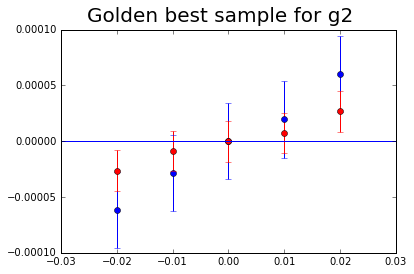

In [20]:
#now for g2
import scipy.odr

plt.suptitle('Golden best sample for g2 ', fontsize=20)
#
medians = [np.median(gold(best(cat))['bias_g2_grp']) for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g2_grp']) for cat in cats]
errs = [mad(gold(best(cat))['bias_g2_grp'])/np.sqrt(len(gold(best(cat)))) for cat in cats]


print 'medians grp:',medians
print 'sigmas grp:',sigmas 
print 'errs grp:',errs

plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',)
plt.ylim(-1e-4,1e-4)


def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#unblended
medians = [np.median(gold(best(cat))['bias_g2']) for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g2']) for cat in cats]
errs = [mad(gold(best(cat))['bias_g2'])/np.sqrt(len(gold(best(cat)))) for cat in cats]
print 'medians iso:',medians
print 'sigmas iso:',sigmas 
print 'errs iso:',errs
plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red')
plt.ylim(-1e-4,1e-4)
plt.axhline(0)

plt.xlim(-.03,.03)

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()





medians grp: [-6.5300483e-08, 3.0509005e-05, -2.2446526e-05, 6.5389024e-05, -5.9134458e-05]
sigmas grp: [0.005766151, 0.0058147814, 0.0057517979, 0.0058418619, 0.0057768282]
errs grp: [2.7655798124385177e-05, 2.7894174689152962e-05, 2.7602518436071336e-05, 2.8042803925450587e-05, 2.7724552461367426e-05]
Beta: [  3.02250731e-03   2.85336330e-06]
Beta Std Error: [  1.24496467e-04   1.75703800e-06]
Beta Covariance: [[  4.28383195e-02   4.46254270e-06]
 [  4.46254270e-06   8.53258611e-06]]
Residual Variance: 3.61810886912e-07
Inverse Condition #: 0.0143075808206
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [3.757556e-07, 1.178247e-05, -3.7361444e-06, 2.6597701e-05, -1.5851097e-05]
sigmas iso: [0.00353528, 0.0035823768, 0.0035594499, 0.0035934111, 0.0035663554]
errs iso: [1.6956023174660387e-05, 1.7185072986829063e-05, 1.7081577492258472e-05, 1.7249521272470162e-05, 1.711589923831041e-05]
Beta: [  1.00569912e-03   3.82033781e-06]
Beta Std Error: [  1.00111470e-04   1.411

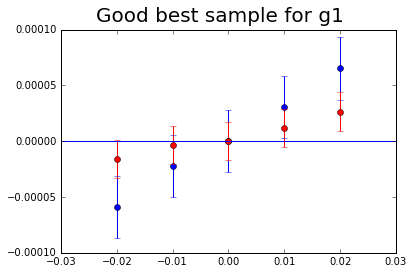

In [21]:
#now with best good! 
import scipy.odr

plt.suptitle('Good best sample for g1 ', fontsize=20)
#
medians = [np.median(good(best(cat))['bias_g1_grp']) for cat in cats]
sigmas = [mad(good(best(cat))['bias_g1_grp']) for cat in cats]
errs = [mad(good(best(cat))['bias_g1_grp'])/np.sqrt(len(good(best(cat)))) for cat in cats]


print 'medians grp:',medians
print 'sigmas grp:',sigmas 
print 'errs grp:',errs

plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',)
plt.ylim(-1e-4,1e-4)


def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#unblended
medians = [np.median(good(best(cat))['bias_g1']) for cat in cats]
sigmas = [mad(good(best(cat))['bias_g1']) for cat in cats]
errs = [mad(good(best(cat))['bias_g1'])/np.sqrt(len(good(best(cat)))) for cat in cats]
print 'medians iso:',medians
print 'sigmas iso:',sigmas 
print 'errs iso:',errs

plt.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red')
plt.ylim(-1e-4,1e-4)
plt.axhline(0)

plt.xlim(-.03,.03)

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()





## money plot with wiki(https://en.wikipedia.org/wiki/Median#Sampling_distribution) variance 

In [11]:
#calculates the density function at the median of catalogues cats, returns list of values at median for each catalogue
#calculates by demanding f(m) has 100 objects involved in its calculation. 
def f_median(cats,param,filters):
    fms = []
    for c in cats: 
        fs =[]
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        n = len(cat)
        med = np.median(cat[param])
        #calculate percentage (%) such that it contains 100 objects 
        p = (100./len(cat))*100.
        w = np.percentile(np.absolute(cat[param] - med),p) #make the median 0 and calculate w around median. 
        cat_cut = cat[ (cat[param] < med + w) &  (cat[param] > med - w)]
        f_m = float(len(cat_cut))/(2*w)
        fms.append((n,f_m))
    return fms
    

In [12]:
#calculates the density function at the median of catalogues cats, returns list of values at median for each catalogue
#tests different widths and returns the first non-zero valued f(m)
def f_median2(cats,param,filters):
    widths = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,.01,.1]
    fms = []
    for c in cats: 
        fs =[]
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        n = len(cat)
        med = np.median(cat[param])
        for w in widths:
            cat_cut = cat[ (cat[param] < med + w) &  (cat[param] > med - w)]
            print len(cat_cut)
            fs.append(float(len(cat_cut))/(2*w))
        fms.append((n,[f for f in fs if f>0][0]))
    return fms
    

In [13]:
#use boostrap 
def sigma_med_boot(cats,param,filters):
    stds = []
    for c in cats: 
        fs =[]
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        n = len(cat)
    
        #generate random N sample with replacement 
        N = 10000
        meds = []
        for i in range(N):
            sample = np.random.choice(cat[param],size=n)
            meds.append(np.median(sample))
            
        stds.append((n,np.std(meds),meds))
    return stds
    

In [14]:
stds_1 = sigma_med_boot(cats,'bias_g1_grp',[gold,best]) #density functions values at the median 
stds_2 = sigma_med_boot(cats,'bias_g1',[gold,best]) #density functions values at the median 

### This is for gold galaxies 

medians grp: [0.031285799195757136, 2.4183353161788546, -2.1035577447037213, 5.8874371461570263, -5.7576478866394609]
sigmas grp: [780.27434647083282, 776.49918384850025, 775.86988918483257, 785.93883663415909, 769.10732313990593]
errs grp: [0.44565726966538932, 0.67572368607216049, 0.66508409872767515, 0.94023289420874789, 0.90678895503515378]
Beta: [  2.78396146e+02   9.35196271e-02]
Beta Std Error: [ 15.19193339   0.21491293]
Beta Covariance: [[  6.81650687e+08   1.07067781e+05]
 [  1.07067781e+05   1.36414604e+05]]
Residual Variance: 3.38582274666e-07
Inverse Condition #: 0.0143405901824
Reason(s) for Halting:
  Sum of squares convergence
278.396145927
[0.0, 0.01, -0.01, 0.02, -0.02, -0.03, 0.03] [0.093519627054497831, 2.8774810863203801, -2.6904418322113846, 5.6614425455862625, -5.4744032914772669, -8.2583647507431497, 8.4454040048521453]
medians iso: [0.037085169424244668, 1.0713732081057969, -0.42288847907911986, 2.8359330826788209, -1.8604681827127934]
sigmas iso: [422.88471013

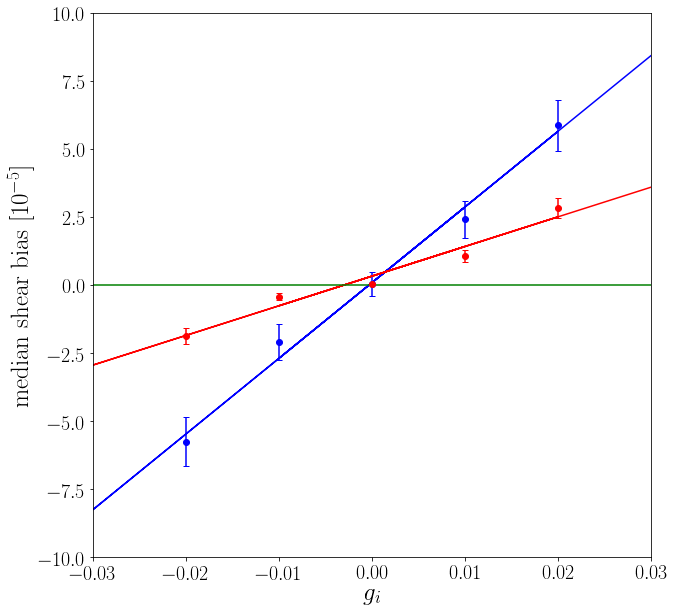

In [62]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
#

#for gold 
import scipy.odr
#
plt.rc('text', usetex=True)


figure = plt.figure(figsize=(10, 10))

#IMPORTANT COMMENT: 
#multiplied times 10**5 for the formatting, actual number is what is displayed times 10**-5! 

####BLENDED 

medians = [np.median(gold(best(cat))['bias_g1_grp'])*10**5 for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g1_grp'])*10**5 for cat in cats]
# use the method describe in the page above for std of the median 
errs = [std[1]*10**5 for std in stds_1]

ax = figure.add_subplot(111)

print 'medians grp:',medians
print 'sigmas grp:',sigmas 
print 'errs grp:',errs
ax.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',capsize=3)

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#plot line, 
beta0 = myoutput.beta[0]
beta1 = myoutput.beta[1]
x= g1s+[-.03,.03]
y = [beta0*g1 + beta1 for g1 in x]
ax.plot(x,y,c='b')



###unblended
medians = [np.median(gold(best(cat))['bias_g1'])*10**5 for cat in cats]
sigmas = [mad(gold(best(cat))['bias_g1'])*10**5 for cat in cats]
# use the method describe in the page above for std of the median 
errs = [std[1]*10**5 for std in stds_2]


print 'medians iso:',medians
print 'sigmas iso:',sigmas 
print 'errs iso:',errs
ax.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3)


linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#plot line, 
beta0 = myoutput.beta[0]
beta1 = myoutput.beta[1]
x = g1s+[-.03,.03]
y = [beta0*g1 + beta1 for g1 in x]
ax.plot(x,y,c='r')

plt.ylim(-10,10)
plt.xlim(-.03,.03)


plt.xticks(size=20)
plt.yticks(size=20)

plt.xlabel(r'$g_i$',size=25)
plt.ylabel(r'\rm median shear bias $[10^{-5}]$',size=25)



# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax.get_yaxis().get_offset_text().set_size(1)

ax.axhline(0,c='g')

plt.savefig('/Users/Ismael/Downloads/money-plot-gold.pdf')




In [58]:
myoutput.beta

array([ 70.84690347,   0.27142149])

4.51682e-06


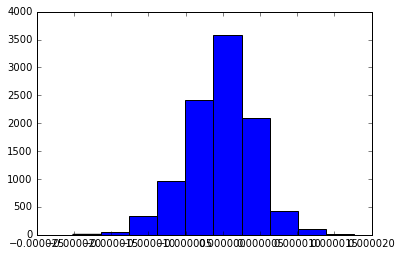

In [26]:
#check that our boostrap medians sample is good 
plt.hist(stds_1[0][2])
print np.std(stds_1[0][2])

In [27]:
stds_1 = sigma_med_boot(cats,'bias_g1_grp',[good,best]) #density functions values at the median 
stds_2 = sigma_med_boot(cats,'bias_g1',[good,best]) #density functions values at the median 

### This is for good galaxies 

medians grp: [-0.0065300483242936025, 3.0509005227941088, -2.2446525690611452, 6.5389023802708834, -5.9134457842446864]
sigmas grp: [576.61510072648525, 581.47814124822617, 575.17979294061661, 584.18619446456432, 577.68281549215317]
errs grp: [0.44565726966538932, 0.67572368607216049, 0.66508409872767515, 0.94023289420874789, 0.90678895503515378]
Beta: [  3.02250731e+02   2.85336302e-01]
Beta Std Error: [ 12.44964618   0.17570381]
Beta Covariance: [[  4.28383162e+08   4.46252773e+04]
 [  4.46252773e+04   8.53258759e+04]]
Residual Variance: 3.61810882629e-07
Inverse Condition #: 0.0143075826445
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [0.037575560440927802, 1.178247021016432, -0.37361444356065476, 2.6597701435093768, -1.585109748702962]
sigmas iso: [353.52800041437149, 358.2376753911376, 355.94499204307795, 359.34110637754202, 356.63554444909096]
errs iso: [0.043958425521850586, 0.20513045910774963, 0.13590467915491899, 0.36437559174373746, 0.29047978387097828]
B

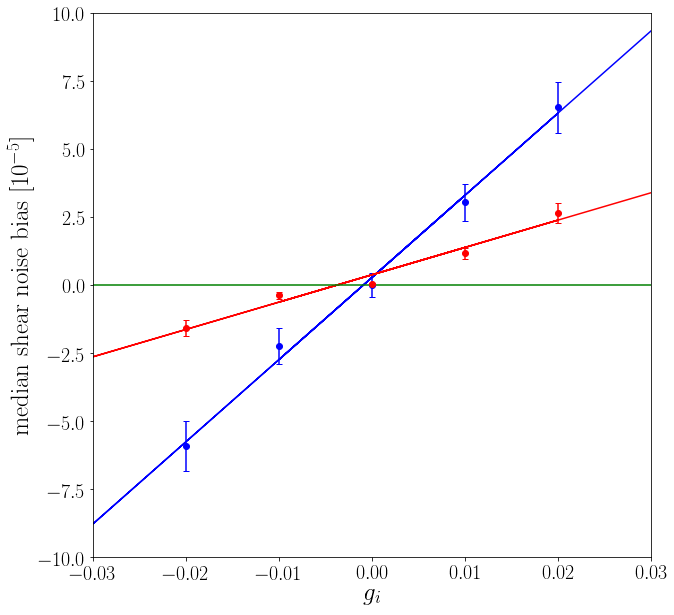

In [64]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
#

#for good 
import scipy.odr
#
plt.rc('text', usetex=True)


figure = plt.figure(figsize=(10, 10))


#IMPORTANT COMMENT: 
#multiplied times 10**5 for the formatting, actual number is what is displayed times 10**-5! 

medians = [np.median(good(best(cat))['bias_g1_grp'])*10**5 for cat in cats]
sigmas = [mad(good(best(cat))['bias_g1_grp'])*10**5 for cat in cats]
# use the method describe in the page above for std of the median 
errs = [std[1]*10**5 for std in stds_1]

ax = figure.add_subplot(111)

print 'medians grp:',medians
print 'sigmas grp:',sigmas 
print 'errs grp:',errs
ax.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',capsize=3)

linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#plot line, 
beta0 = myoutput.beta[0]
beta1 = myoutput.beta[1]
x= g1s+[-.03,.03]
y = [beta0*g1 + beta1 for g1 in x]
ax.plot(x,y,c='b')

#unblended
medians = [np.median(good(best(cat))['bias_g1'])*10**5 for cat in cats]
sigmas = [mad(good(best(cat))['bias_g1'])*10**5 for cat in cats]
# use the method describe in the page above for std of the median 
errs = [std[1]*10**5 for std in stds_2]


print 'medians iso:',medians
print 'sigmas iso:',sigmas 
print 'errs iso:',errs
ax.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3)


linear = scipy.odr.Model(f)
mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()

#plot line, 
beta0 = myoutput.beta[0]
beta1 = myoutput.beta[1]
x= g1s+[-.03,.03]
y = [beta0*g1 + beta1 for g1 in x]
ax.plot(x,y,c='r')


plt.ylim(-10,10)
plt.xlim(-.03,.03)

ax.axhline(0,c='g')

plt.xticks(size=20)
plt.yticks(size=20)

plt.xlabel(r'$g_i$',size=25)
plt.ylabel(r'\rm median shear noise bias $[10^{-5}]$',size=25)

# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

ax.get_yaxis().get_offset_text().set_size(40)

plt.savefig('/Users/Ismael/Downloads/money-plot-good.pdf')


### Check snr of objects close to the median. 

percentage of objects with snr_grpf greater than 10: 0.99


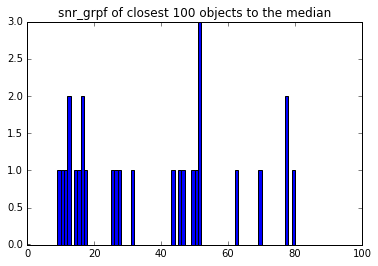

In [33]:
cat = best(gold(cats[0]))
param = 'bias_g1_grp'
med = np.median(cat[param])
n = 100.
p = (n/len(cat))*100.
w = np.percentile(np.absolute(cat[param] - med),p)
cat_cut = cat[ (cat[param] < med + w) &  (cat[param] > med - w)]
plt.hist(cat_cut['snr_grpf'],range=(0,100),bins=100)
plt.title('snr_grpf of closest {0:0g} objects to the median'.format(n))
print 'percentage of objects with snr_grpf greater than 10:', float(len(cat_cut[cat_cut['snr_grpf']>10]))/len(cat_cut)

(array([ 11.,   9.,  10.,   6.,  10.,  10.,  11.,  14.,   9.,  10.]),
 array([ -1.48450374e-06,  -1.12554693e-06,  -7.66590119e-07,
         -4.07633308e-07,  -4.86764975e-08,   3.10280313e-07,
          6.69237124e-07,   1.02819394e-06,   1.38715075e-06,
          1.74610756e-06,   2.10506437e-06]),
 <a list of 10 Patch objects>)

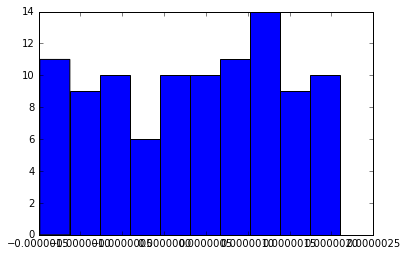

In [44]:
plt.hist(cat_cut['bias_g1_grp'])

In [34]:
np.median(cat_cut[param])

4.2850678e-07

### what are these 50 objects with vey low snr_grpf but very close to the median of bias_g1_grp

(array([      0.,       0.,       0.,       0.,       0.,  387167.,
         177279.,   77485.,   43903.,   28956.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

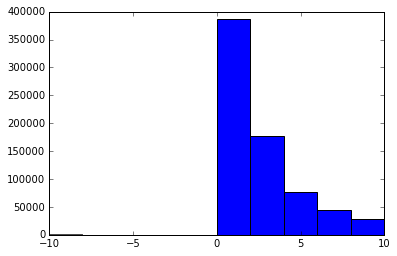

In [35]:
plt.hist(cats[0]['snr_grpf'],range=(-10,10))


### Could this rare objects originate from artificial borders? (it seems that no) 

In [39]:
rare_objs = abs_cut(cat_cut,'snr_grpf',2)

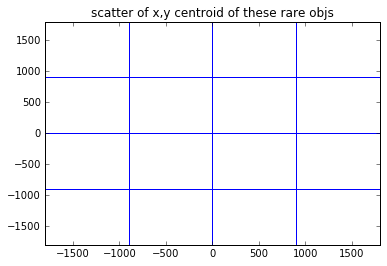

In [40]:
extend = 3600./2
plt.scatter(rare_objs['dx'],rare_objs['dy'])
plt.title('scatter of x,y centroid of these rare objs')
plt.xlim(-extend,extend)
plt.ylim(-extend,extend)

#put hor/vert lines to check hypothesis
for x in np.linspace(0,extend,3):
    plt.axhline(x)
    plt.axhline(-x)
    plt.axvline(x)
    plt.axvline(-x)
        

numer of objects: 0
mean of bias_g2_grp: nan


/Users/Ismael/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Ismael/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

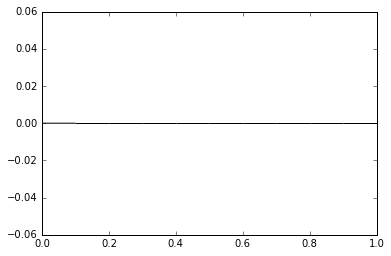

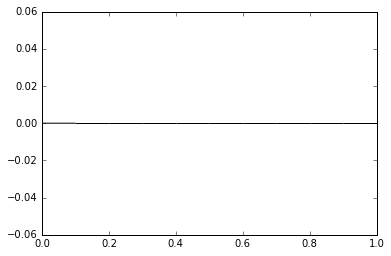

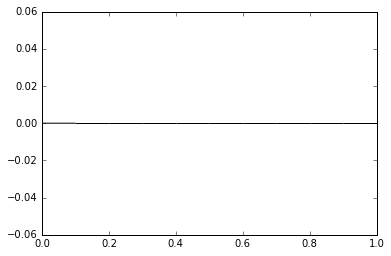

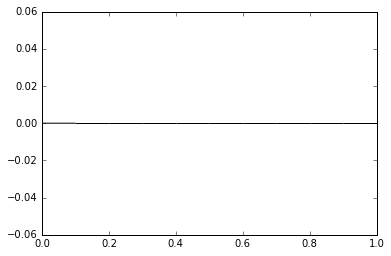

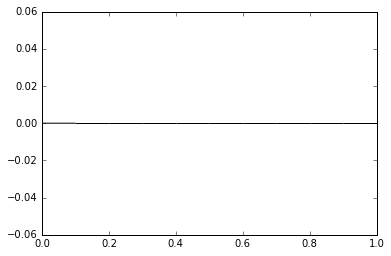

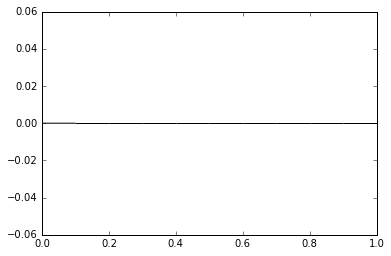

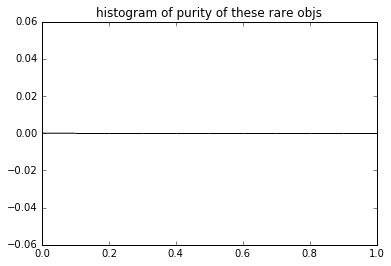

In [41]:
#suspicion, high bias_g2_grp ---> wrong! 
print 'numer of objects:',len(rare_objs)
plt.figure()
plt.hist(rare_objs['snr_grpf'])
plt.figure()
plt.hist(rare_objs['bias_g2_grp'])
print 'mean of bias_g2_grp:', np.median(rare_objs['bias_g2_grp'])
plt.figure()
plt.hist(rare_objs['sigma_m'])
plt.figure()
plt.hist(rare_objs['e1'])
plt.figure()
plt.hist(rare_objs['e2'])
plt.figure()
plt.hist(rare_objs['ab_mag'])
plt.figure()
plt.title('histogram of purity of these rare objs')
plt.hist(rare_objs['purity'])

### looking at these objects might illuminate us

In [49]:
f = fits.open('/Users/Ismael/temp_data/.fits')
t = Table.read(f,hdu=1)

In [56]:
f[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                18000                                                  
NAXIS2  =                18000                                                  
EXTEND  =                    T                                                  
NSLICES =                   21                                                  
PSF_SIGM=   0.6166557071664878                                                  
PSF_SIGP=   0.6166557071664878                                                  
PSF_HSM =   0.3458685398101807                                                  
URE_TIME=               6900.0                                                  
IGHTNESS=                 20.0                                                  
DIAMETER=    8.3599999999999

In [48]:
rare_objs

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702901907,402700083686,14,3,1,1795,1812,2604,2620,1.0,0.0,-1439.25,-377.465,0.487389,24.7755,0.441755,138384.0,0.3261,0.335823,0.0913279,0.14501,0.387721,0.274273,0.504376,0.701148,0.973771,22.9271,22.8626,0.0,15.0085,0.0,0.139894,0.122503,0.127106,inf,inf,inf,nan,nan,nan,0.0,0.0,679.005,-0.0224086,0.00679516,0.0107998,-6.5909e-07,-9.42657e-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102121,False
402700083686,402700083686,14,0,1,1726,1811,2619,2661,0.81401,0.18599,-1446.21,-371.929,0.765379,20.8211,0.8915,5.28268e+06,1.07661,1.57026,0.550617,-0.239352,2.15453,0.537975,-0.205028,1.35423,0.994833,476.363,459.958,0.0,257.502,0.0,0.00547794,0.00417483,0.00260081,inf,inf,inf,nan,nan,nan,0.0,0.0,66.7773,-1.2286e-05,2.33172e-05,-1.01458e-05,1.91149e-11,3.07506e-11,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102164,False
402701456831,402700005120,190,31,1,383,406,2698,2715,0.993656,0.00634408,-1721.06,-358.557,3.22464,23.9957,0.00880051,283793.0,0.380344,0.466222,0.365305,-0.259558,0.616114,0.234797,-0.308877,0.75841,0.881101,44.0857,43.8616,0.0,28.6463,0.0,0.0872943,0.0719142,0.0604243,inf,inf,inf,nan,nan,nan,0.0,0.0,371.235,-0.00877109,0.00845146,-0.00600561,-7.55705e-08,4.66139e-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,103492,False
402701021226,402700005120,190,20,1,364,384,2685,2707,0.831083,0.168917,-1725.09,-360.737,1.21783,23.5662,0.470728,421512.0,0.267078,0.381857,-0.332291,0.482284,0.522486,0.136522,1.08705,0.714476,0.977124,72.6204,71.9415,0.0,44.775,0.0,0.133752,0.0790925,0.107789,inf,inf,inf,nan,nan,nan,0.0,0.0,135.764,-0.0202215,-0.0154622,0.0224444,-3.96885e-09,9.31766e-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,103064,False
402700067540,402700005120,190,2,1,350,412,2638,2699,0.157402,0.826218,-1723.73,-366.281,0.33741,20.8682,0.581371,5.05832e+06,0.413373,0.414293,0.0133844,-0.0452118,0.433346,0.394321,-0.641489,0.742743,0.994044,706.346,651.26,0.0,270.687,0.0,0.0101395,0.00547644,0.00562645,inf,inf,inf,nan,nan,nan,0.0,0.0,45.6947,-9.97191e-06,1.89986e-06,-6.40045e-06,8.81186e-11,-1.13352e-10,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102579,False
402702256752,402700005120,190,39,1,362,376,2655,2669,1.0,0.0,-1726.11,-367.441,0.337581,24.6455,0.61237,155996.0,0.0977656,0.144438,0.445232,-0.416377,0.198511,0.0481491,-0.375961,0.633007,0.820046,32.477,32.3146,0.0,23.262,0.0,1.76893,1.31265,1.23297,inf,inf,inf,nan,nan,nan,0.0,0.0,472.447,-5.02513,4.72185,-4.41567,-3.85292e-06,-1.51138e-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102474,False
402700111942,402700005120,190,4,1,444,496,2734,2801,0.111331,0.821832,-1705.9,-346.347,0.337581,21.2069,0.584993,3.70293e+06,0.470949,0.48233,-0.143315,-0.0577423,0.550325,0.403023,-1.37929,0.780302,0.962001,494.896,467.188,0.0,185.981,0.0,0.0141106,0.00759592,0.0072371,inf,inf,inf,nan,nan,nan,0.0,0.0,65.3961,-1.51962e-05,-2.81955e-05,-1.1362e-05,1.23437e-10,4.7064e-11,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,104197,False
402703411689,402700005120,190,56,1,421,437,2756,2771,0.905381,0.0946188,-1714.08,-347.26,2.15858,25.1231,0.0283527,100471.0,0.372602,0.399367,0.0875823,-0.24817,0.487858,0.284576,-0.615764,0.730765,0.683647,16.2522,16.2195,0.0,10.2701,0.0,0.263711,0.170877,0.236103,inf,inf,inf,nan,nan,nan,0.0,0.0,848.307,-0.0806415,0.0283016,-0.0802049,8.8

In [54]:
#check first 10 objects
extend = 10.
init = 5000 
fin = 5010 
for i,row in enumerate(t[init:fin]):
    print cmd 
    cmd = './display.py -o {0} --input-name {1} --view-region [{2},{3},{4},{5}] --no-display'.format('/Users/Ismael/temp_data/field_finalfits_{0}.pdf'.format(i+init),'/Users/Ismael/temp_data/final_fits1.fits',row['dx']-extend,row['dx']+extend,row['dy']-extend,row['dy']+extend)
    out = subprocess.check_output(cmd,shell=True)
    print out 

./display.py -o /Users/Ismael/temp_data/field_finalfits_3009.pdf --input-name /Users/Ismael/temp_data/final_fits1.fits --view-region [-1398.29162598,-1388.29162598,-1798.24462891,-1788.24462891] --no-display

./display.py -o /Users/Ismael/temp_data/field_finalfits_5000.pdf --input-name /Users/Ismael/temp_data/final_fits1.fits --view-region [-919.759765625,-899.759765625,-1718.47119141,-1698.47119141] --no-display

./display.py -o /Users/Ismael/temp_data/field_finalfits_5001.pdf --input-name /Users/Ismael/temp_data/final_fits1.fits --view-region [-917.132995605,-897.132995605,-1715.63427734,-1695.63427734] --no-display

./display.py -o /Users/Ismael/temp_data/field_finalfits_5002.pdf --input-name /Users/Ismael/temp_data/final_fits1.fits --view-region [-917.155334473,-897.155334473,-1715.77832031,-1695.77832031] --no-display

./display.py -o /Users/Ismael/temp_data/field_finalfits_5003.pdf --input-name /Users/Ismael/temp_data/final_fits1.fits --view-region [-917.995605469,-897.995605469,

### Are these objects near the median or near 0 once the cosmic shear is applied? 

In [114]:
cat2 = best(gold(cats[1])) #assume same galaxies pass cut. 
cat_new =cat2[(cat2['db_id'] == cat_cut['db_id'])]
print np.median(cat2['bias_g1_grp'])
print np.median(cat_new['bias_g1_grp'])



2.16545e-05
0.0210082


In [69]:
np.percentile(np.absolute(cat[param] - med),.1)

2.853042326478317e-07

In [96]:
1./(1e-17)**2

9.999999999999998e+33

In [11]:
cat = fits.open(files_temps['final_fits1'])

In [15]:
t = Table.read(cat[1]) 

In [16]:

t

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402703800921,402700070321,14,4,1,63,78,4435,4449,0.979957,0.0200425,-1785.79,-911.452,1.10249,25.118,0.304281,100951.0,0.280908,0.287157,0.107846,0.10181,0.326177,0.241922,0.378307,0.679782,0.99283,17.62,17.5798,17.5797,11.6366,11.55,0.20813,0.189111,0.188379,0.209643,0.189235,0.189312,nan,nan,nan,0.0,2.98023e-09,885.573,-0.0536606,0.019716,0.0186084,1.20218e-06,2.17978e-07,846.358,-0.0550999,0.0196308,0.0200551,0.000114121,-6.89414e-05,62918,False
402711741705,402700070321,14,11,1,48,56,4441,4450,1.0,0.0,-1789.49,-910.732,1.7324,27.0767,0.483753,16619.1,0.136951,0.169101,-0.412124,-0.194816,0.224008,0.0837271,-1.35001,0.638975,0.708771,3.35006,3.34837,3.34785,2.3052,2.10892,5.09399,4.65826,2.87848,5.24664,4.72975,2.9207,nan,nan,nan,0.0,0.0,5632.62,-42.2587,-45.489,-21.5245,-0.00060437,0.00156415,6098.27,-43.7503,-47.4022,-22.59,0.00227608,0.00415418,-1,False
402700888931,402700157436,6,1,1,-10,12,4426,4445,0.984052,0.0159475,-1799.74,-912.788,0.564225,23.3659,0.708736,506909.0,0.312205,0.373293,0.247482,-0.339966,0.488806,0.199409,-0.470774,0.714129,0.998528,84.9669,84.0811,84.0808,55.8643,55.8625,0.0537954,0.0384234,0.0448485,0.0537965,0.0384241,0.0448489,nan,nan,nan,0.0,2.98023e-09,186.334,-0.00364419,0.00243869,-0.00335012,-1.38445e-09,3.24792e-09,186.15,-0.00364542,0.00243957,-0.0033502,-4.33745e-08,9.07668e-08,-1,False
402700157436,402700157436,6,0,1,-7,36,4403,4437,0.979011,0.0209888,-1796.94,-915.903,0.978547,21.2337,0.357725,3.61274e+06,0.552112,0.642985,0.384919,-0.0551429,0.8323,0.366247,-0.0711453,0.861934,0.999263,469.728,449.528,449.527,289.384,285.028,0.00562225,0.00499328,0.00350777,0.00576322,0.00512956,0.00352524,nan,nan,nan,0.0,2.98023e-09,39.0377,-2.74528e-05,2.98148e-05,-4.27184e-06,-2.55419e-11,1.85468e-11,-102.075,-0.000102954,9.69304e-05,-2.51873e-05,3.9072e-06,1.3913e-05,62901,False
402710043179,402700157436,6,4,1,14,25,4437,4447,1.0,0.0,-1795.99,-911.534,1.9369,26.7302,-0.0148411,22866.9,0.338655,0.342763,0.102475,0.039454,0.378129,0.303302,0.183759,0.705051,0.999558,3.72547,3.72377,3.72377,2.31122,2.31122,0.860507,0.774936,0.7525,0.860507,0.774936,0.7525,nan,nan,nan,0.0,0.0,5915.07,-0.647236,0.259546,0.0999777,0.000937364,-0.000385944,5915.08,-0.647236,0.259546,0.0999779,0.000937307,-0.000386045,-1,False
402716543735,402716543735,1,0,1,2,9,4360,4367,1.0,0.0,-1798.77,-927.204,3.06535,27.8187,-0.0392017,8391.27,0.151304,0.160452,0.209959,-0.120637,0.193707,0.118183,-0.260758,0.637054,1.0,1.67006,1.66963,1.66963,1.07274,1.07274,5.62974,5.15311,4.59607,5.62974,5.15311,4.59607,nan,nan,nan,0.0,0.0,15828.7,-49.7808,35.6115,-20.6862,0.0143205,0.00312236,15828.7,-49.7808,35.6115,-20.6862,0.0143205,0.00312236,-1,False
402700326587,402700326587,11,0,1,19,48,4373,4405,0.958816,0.0411839,-1793.2,-922.138,0.55267,22.4916,0.557438,1.13411e+06,0.611041,0.643435,-0.103375,0.2023,0.769992,0.484903,1.0216,0.879698,0.938179,139.122,137.324,137.273,83.7917,60.7617,0.0165666,0.0129921,0.0139023,0.0204651,0.0144399,0.0186831,nan,nan,nan,0.0,2.98023e-09,140.606,-0.000181832,-6.36296e-05,0.000124498,-1.26983e-09,-4.54258e-09,-1012.5,-0.00149075,0.000156636,0.000660477,7.71152e-05,3.09066e-06,62932,False
402709202217,402700

In [19]:

print len(t)
print len(set(t['db_id']))

861061
857153


In [ ]:
#objects that have same 'db_id'??? 

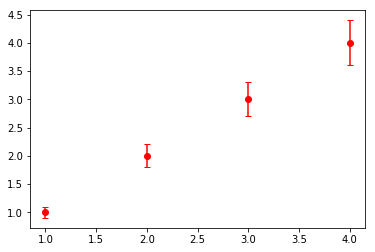

In [35]:
x = [1,2,3,4]
y = [1,2,3,4]
errs = [.1,.2,.3,.4]
plt.errorbar(x,y,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3)
plt.savefig('/Users/Ismael/error.pdf')
